In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2,RealAmplitudes

from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from itertools import product
from scipy.optimize import minimize

In [2]:
noise = False 
n_qubits = 4
n_reps = 4
#nShots = 2**16
nShots = int(1e5)
print("nShots = ", nShots)


nShots =  100000


In [3]:
class VQE():
    
    def __init__(self,n_qubits = 4, n_reps = 5,shots=2**15,seed=None,noise = None,w = None):
        self.n_qubits = n_qubits
        self.n_reps = n_reps
        self.shots = shots
        self.seed = seed
        self.noise = noise
        self.H = None
        self.loss_history = []
        self.sampler = None
        self.estimator = None
        self.pm = None
        
        
        self.qc = QuantumCircuit(n_qubits)
        ansatz = RealAmplitudes(num_qubits=n_qubits, reps=n_reps, parameter_prefix='w')
        parameters = list(ansatz.parameters)
        self.qc.compose(ansatz, inplace=True)
        self.isa_qc = None
        if w!= None:
            self.w = w
        else:
            self.w = np.random.rand(len(self.qc.parameters))*2*np.pi
        
        self.boundCircuit = None
        
    def transpile(self):

        aer = AerSimulator()

        if self.noise:
            service = QiskitRuntimeService()
            real_backend = service.backend("ibm_kawasaki")
            aer = AerSimulator.from_backend(real_backend)
            self.estimator = Estimator(mode=aer)
            self.sampler = Sampler(mode = aer)
            self.pm = generate_preset_pass_manager(backend=aer, optimization_level=3)

        else:
            self.estimator = Estimator( mode = aer)
            self.sampler = Sampler( mode = aer)
            self.pm = generate_preset_pass_manager(backend=aer, optimization_level=3)

            self.isa_qc = self.pm.run(self.qc) 
            
    def getH(self):
        ob_list = []
        for i in range(1,n_qubits,1):
            ob = SparsePauliOp.from_list([("I"*(i ) + "Z" + "I"* ( n_qubits - i-1), 1)])
            ob = ob.apply_layout(layout=self.isa_qc.layout)
            ob_list.append(ob)

            ob = SparsePauliOp.from_list([("I"*(i ) + "X" + "I"* ( n_qubits - i-1), 1)])
            ob = ob.apply_layout(layout=self.isa_qc.layout)
            ob_list.append(ob)
        hamiltonian = sum(ob_list[1:], ob_list[0]) 
        self.H = hamiltonian

        
    def loss(self,w):
        
        result = self.estimator.run([(self.isa_qc,self.H,w)],precision = 0.005) # precision = 1 to sample only one time.
        evs = result.result()[0].data.evs
        return evs
    
    def train(self, maxiter=100):
        w = self.w

        def callback(w):
            current_loss = self.loss(w)
            self.loss_history.append(current_loss)

        res = minimize(self.loss, w, method='COBYLA', callback=callback, options={'maxiter': maxiter})
        self.w = res.x
        return res.x
    def getBoundCircuit(self):

        param_dict = {param: value for param, value in zip(self.qc.parameters, self.w )}
        qc_bound = self.qc.copy().assign_parameters(param_dict,inplace=False)
        self.boundCircuit = self.pm.run(qc_bound)
        return qc_bound

    def getDistribution(self,w = None):
        if w == None:
            w = self.w
        
        tmp_circuit = self.qc.copy()
        tmp_circuit.measure_all()
        circuit = self.pm.run(tmp_circuit)
        job = self.sampler.run([(circuit, w)], shots=self.shots)
        result = job.result()[0].data.meas.get_counts()
    
        probs = {k: v / self.shots for k, v in result.items()}
        return probs
    


In [4]:
vqe = VQE(n_qubits = n_qubits, n_reps = n_reps)
vqe.transpile()
vqe.getH()
vqe.train()

array([1.33675508, 2.30004564, 1.87346739, 7.39954235, 5.16752906,
       3.34509434, 4.68961983, 5.51954442, 6.17391223, 3.85050738,
       0.47670241, 3.94573097, 5.99930149, 5.80236332, 2.37310755,
       3.32551063, 4.87509795, 1.6579759 , 6.62722655, 2.85537406])

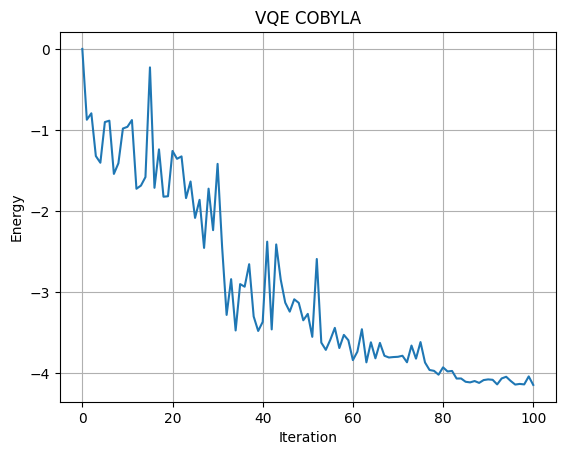

In [5]:
plt.plot(vqe.loss_history,label = "VQE")
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE COBYLA')
plt.grid()

Compiling

In [6]:
boundCircuit = vqe.getBoundCircuit()


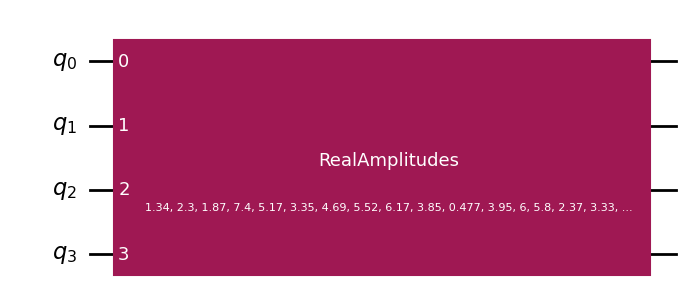

In [7]:
boundCircuit.draw('mpl')

In [8]:
vqe.getDistribution()

{'1111': 0.39312744140625,
 '1011': 0.08135986328125,
 '1101': 0.048126220703125,
 '0101': 0.0606689453125,
 '1110': 0.05902099609375,
 '0111': 0.21453857421875,
 '0110': 0.05670166015625,
 '0011': 0.02935791015625,
 '0100': 0.008392333984375,
 '1001': 0.025634765625,
 '0010': 0.000732421875,
 '0001': 0.0079345703125,
 '1000': 0.001556396484375,
 '1010': 0.01220703125,
 '0000': 0.000640869140625}

In [9]:
class compiler():
    def __init__(self,state_qc,n_reps = 5,shots=2**15,noise = None,w=None,seed = None):
        self.qc = state_qc.copy()
        ansatz = EfficientSU2(num_qubits=state_qc.num_qubits, reps=n_reps, parameter_prefix='w')
        self.ansatz = ansatz
        parameters = list(ansatz.parameters)
        self.qc.compose(self.ansatz, inplace=True)
        self.qc.measure_all()
        
        self.n_qubits = self.qc.num_qubits
        self.basis = '0'*self.n_qubits
        self.noise= noise
        self.shots = shots
        self.seed = seed

        # Backend and tools
        self.pm = None
        self.backend = None
        self.sampler = None
       
        
        if w!= None:
            self.w = w
        else:
            self.w = np.random.rand(len(self.qc.parameters))*2*np.pi
            
        self.loss_history = []
        self.compiledQC = None
        
    def transpile(self):

        self.backend = AerSimulator(seed_simulator=self.seed)

     
        if self.noise:
            service = QiskitRuntimeService()
            real_backend = service.backend("ibm_kawasaki")
            aer = AerSimulator.from_backend(real_backend)
            self.estimator = Estimator(mode=aer)
            self.sampler = Sampler(mode = aer)
            self.pm = generate_preset_pass_manager(backend=aer, optimization_level=3)
        else:

            self.pm = generate_preset_pass_manager(backend=self.backend, optimization_level=3)
            self.sampler = Sampler( mode = self.backend)
            self.isa_qc = self.pm.run(self.qc) 
            
    
    def loss(self,w):
        job = self.sampler.run([(self.isa_qc, w)], shots=self.shots)
        result = job.result()[0].data.meas.get_counts()
        if self.basis not in result.keys():
            return 1
        else:
            return (self.shots-result[self.basis]) / self.shots
        
    
    def train(self, maxiter=300):
        w = self.w

        def callback(w):
            current_loss = self.loss(w)
            self.loss_history.append(current_loss)

        res = minimize(self.loss, w, method='COBYLA', callback=callback, options={'maxiter': maxiter})
        self.w = res.x
        return res.x
    
    def compiledCircuit(self):
        inv = self.ansatz.copy().inverse()
        qc= QuantumCircuit(self.n_qubits)
        qc.compose(inv, inplace = True)
        qc.measure_all()
        self.compiledQC = self.pm.run(qc) 
    
    def getDistribution(self,w = None):
        if w == None:
            w = self.w
        job = self.sampler.run([(self.compiledQC, w)], shots=self.shots)
        result = job.result()[0].data.meas.get_counts()
    
        probs = {k: v / self.shots for k, v in result.items()}
        return probs
        
        
        

In [10]:
comp_qc = compiler(boundCircuit)
comp_qc.transpile()
comp_qc.train()

array([ 2.04925028,  8.27996056,  3.0708607 ,  5.51541599,  3.98672474,
        6.39583542,  1.60682384,  0.3741276 ,  3.26587261,  6.89756483,
        1.10656263,  4.1089509 ,  3.34878736,  2.420763  ,  3.42995747,
        3.77226686,  2.72356686,  2.2477693 ,  4.55180329,  0.75090269,
        7.15003393,  5.28049703,  1.95760878,  2.56029973,  6.35059801,
        2.36817131,  6.39431952,  3.80880819,  3.87062469, -0.21789674,
        3.23786433,  2.97935595,  3.19494198,  2.45335002,  3.10911342,
        2.56246183,  2.57540921,  7.04133228,  5.88301125,  2.51941594,
        3.20699083,  3.49979238, -0.06467909,  4.03943387,  3.54930157,
        5.20013093,  5.75139321,  5.63177693])

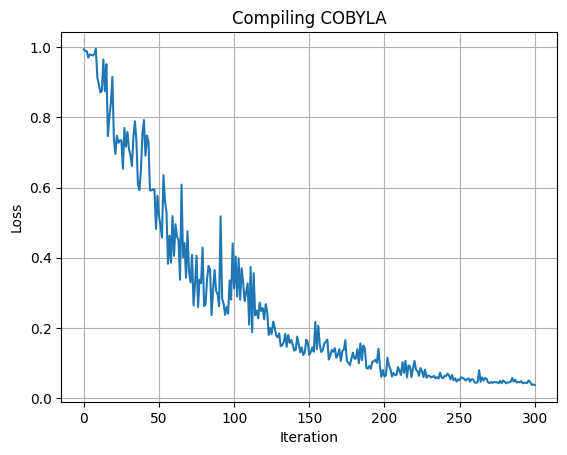

In [11]:
plt.plot(comp_qc.loss_history)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Compiling COBYLA')
plt.grid()

In [12]:
comp_qc.compiledCircuit()

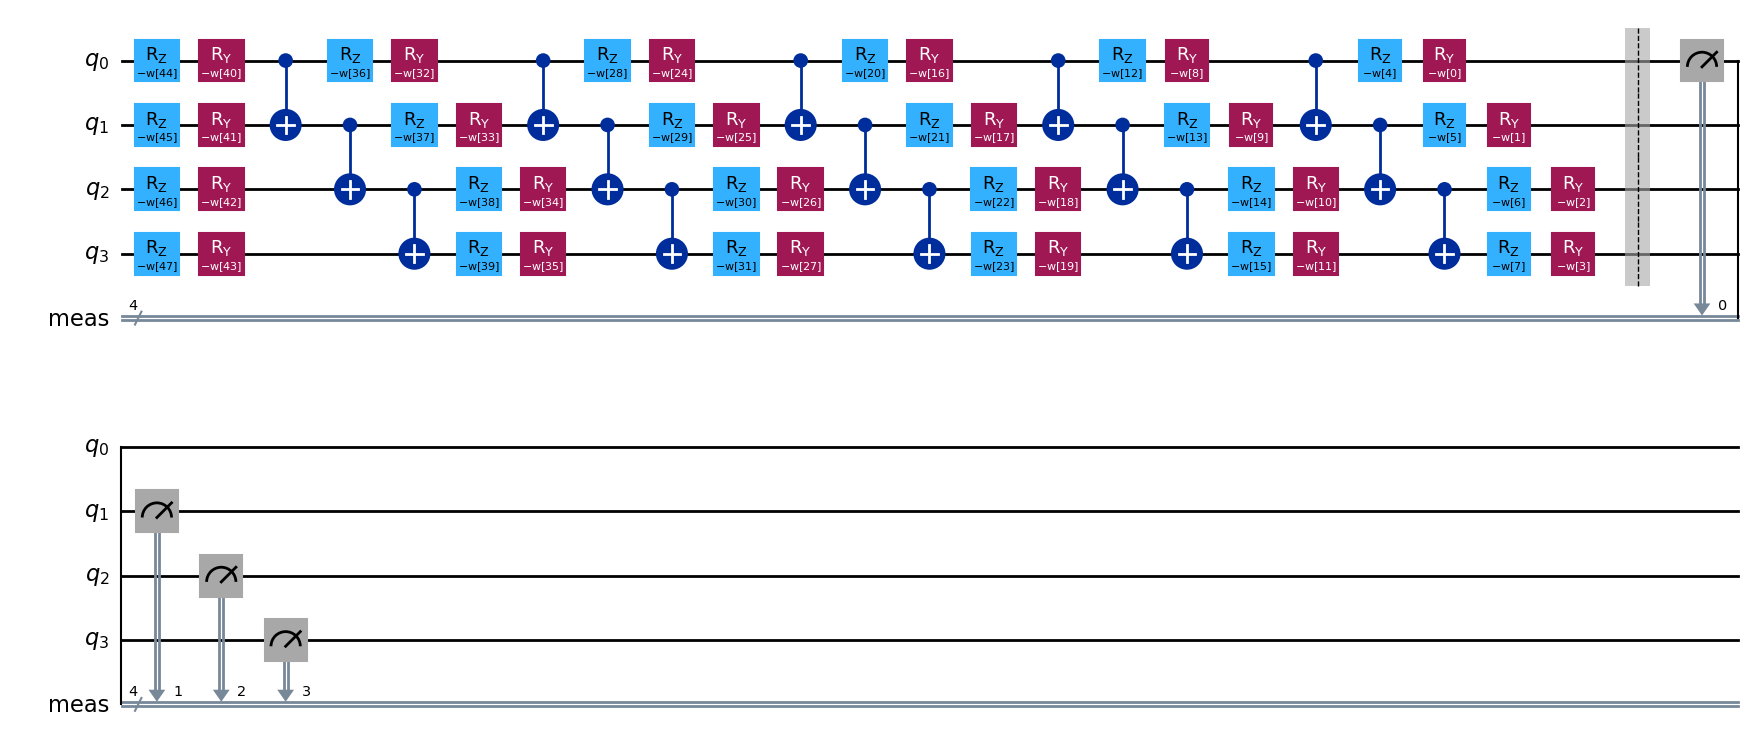

In [13]:
comp_qc.compiledQC.draw('mpl')

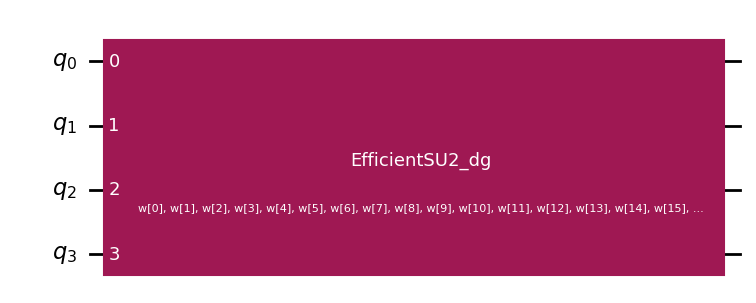

In [14]:
comp_qc.ansatz.inverse().draw('mpl')

In [15]:
comp_qc.getDistribution()

{'1011': 0.109466552734375,
 '1111': 0.39349365234375,
 '1110': 0.0728759765625,
 '0111': 0.20513916015625,
 '0110': 0.03826904296875,
 '0101': 0.081329345703125,
 '1010': 0.01318359375,
 '1101': 0.024139404296875,
 '0001': 0.006927490234375,
 '1001': 0.02001953125,
 '0010': 0.00286865234375,
 '0100': 0.013641357421875,
 '0011': 0.00982666015625,
 '1100': 0.002777099609375,
 '0000': 0.003143310546875,
 '1000': 0.002899169921875}

In [16]:
def plotDist(target_dict,d_comp,label = 'Compiler',plotTarget = True):
    h_comp = []
    h_target = []
    
    for key in target_dict.keys():
        h_target.append(target_dict[key])
        if key in d_comp.keys():
            h_comp.append(d_comp[key])
        else:
            h_comp.append(0)
    if plotTarget:
        plt.bar(range(len(target_dict.keys())),h_target,label = 'Target')
    plt.bar(range(len(target_dict.keys())),h_comp,alpha = 0.3,label = label)
    plt.legend()
        
        
        

In [17]:
target_dict = vqe.getDistribution()
compiler_dict = comp_qc.getDistribution()

Text(0, 0.5, 'Probability')

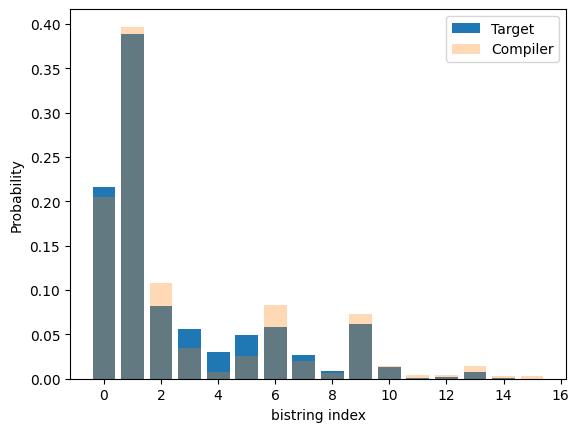

In [18]:
plotDist(target_dict,compiler_dict,label = 'Compiler')
plt.xlabel("bistring index")
plt.ylabel("Probability")

QCBM

In [21]:

class QCBM:
    def __init__(self,n_qubits, n_reps,  target_dict,shots=2**15, scales = np.array([0.01, 0.1, 1, 10, 100]),seed=None):
        self.n_qubits = n_qubits
        self.n_reps = n_reps
        self.shots = shots
        self.seed = seed
        self.scales = scales

        # Build quantum circuit
        self.qc = QuantumCircuit(n_qubits)
        self.ansatz = RealAmplitudes(num_qubits=n_qubits, reps=n_reps, parameter_prefix='w')
        self.parameters = list(self.ansatz.parameters)
        self.qc.compose(self.ansatz, inplace=True)
        self.qc.measure_all()

        # Backend and tools
        self.backend = AerSimulator(seed_simulator=seed)
        self.pm_sim = generate_preset_pass_manager(backend=self.backend, optimization_level=3)
        self.sampler = Sampler(mode = self.backend)
        
        # Precompute bitstrings and target vector q
        self.bitstrings = sorted(set(target_dict.keys()))
        self.X = np.array([self.bitstring_to_array(bs) for bs in self.bitstrings])
        self.q = np.array([target_dict[bs] if bs in target_dict else 0 for bs in self.bitstrings])
        
        self.theta = self.random_theta()
        # History for loss tracking
        self.loss_history = []

    def sample(self, theta):

        # Transpile circuit
        transpiled_qc = self.pm_sim.run(self.qc)
        # Run sampler
   
        job = self.sampler.run([(transpiled_qc, theta)], shots=self.shots)
        result = job.result()[0].data.meas.get_counts()
   
        # Normalize counts to probabilities
        probs = {k: v / self.shots for k, v in result.items()}
        return probs
    
    def loss(self, theta):

        result = self.sample(theta)
       
        p = np.array([result[bs] if bs in result else 0 for bs in self.bitstrings])
        return self.getMMD2(p, self.q, self.X, scales = self.scales)

    @staticmethod
    def bitstring_to_array(bs): # Converting bitstring to vector arrays for kernel evaluation
        return np.array([int(b) for b in bs])

    @staticmethod
    def getMMD2(p, q, X,scales):
        sq_dists = np.linalg.norm(X[:, None] - X[None, :], axis=-1) ** 2
        gamma = 1 / (2 * scales ** 2)
        K = np.exp(-gamma[:,None,None] * sq_dists).sum(axis = 0)/len(scales)
        return (p - q) @ K @ (p - q)

    def random_theta(self):
        return np.random.uniform(0, 2 * np.pi, len(self.parameters))
    
    def train(self, maxiter=200):
        theta0 = self.random_theta()

        def callback(theta):
            current_loss = self.loss(theta)
            self.loss_history.append(current_loss)

        res = minimize(self.loss, theta0, method='COBYLA', callback=callback, options={'maxiter': maxiter})
        qcbm.theta = res.x
        return res.x


In [24]:
qcbm = QCBM(n_qubits,n_reps,target_dict,shots = nShots)
qcbm.sample(qcbm.theta)
qcbm.train()

array([ 4.50887534,  0.94856573,  4.66555995,  5.86658244,  1.36005889,
        1.04833963, -0.34206394,  1.43999784,  2.61996736,  2.12804321,
        5.79539513,  2.63801217,  0.71545812,  3.96322512,  4.22656243,
        0.91614098,  5.85504829,  5.73025839,  5.88754327,  0.08548316])

In [25]:
qcbm_dict = qcbm.sample(qcbm.theta)

Text(0, 0.5, 'Probability')

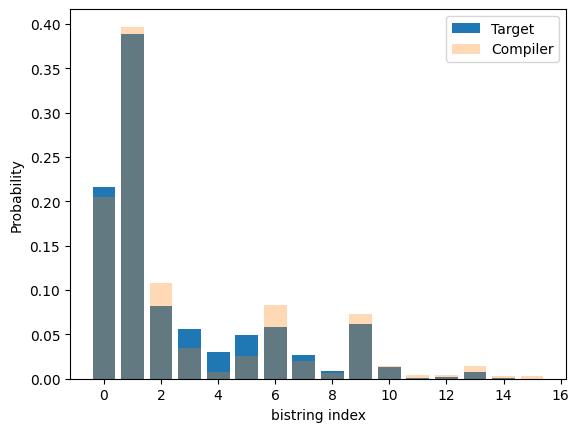

In [26]:
plotDist(target_dict,compiler_dict,label = 'Compiler')
#plotDist(qcbm_s,target_dict,qcbm_label = '1 scale',plotTarget = False)
plt.xlabel("bistring index")
plt.ylabel("Probability")

Text(0, 0.5, 'Probability')

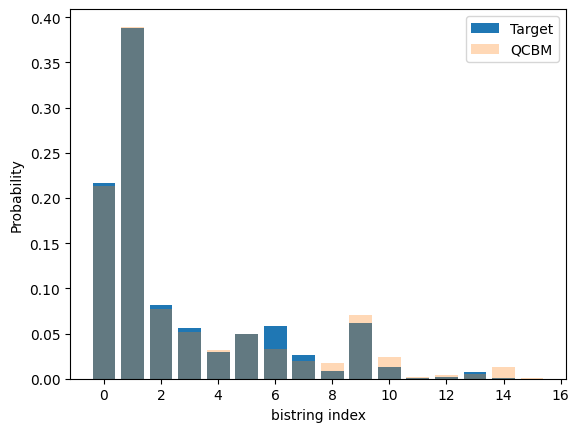

In [28]:
plotDist(target_dict,qcbm_dict,label = 'QCBM')
plt.xlabel("bistring index")
plt.ylabel("Probability")

In [33]:
def bitstring_to_array(bs): # Converting bitstring to vector arrays for kernel evaluation
        return np.array([int(b) for b in bs])
    
def computeMMD(result,target_dict, scales = np.array([0.01, 0.1, 1, 10, 100])):
    bitstrings = sorted(set(target_dict.keys()))
    X = np.array([bitstring_to_array(bs) for bs in bitstrings])
    q = np.array([target_dict[bs] if bs in target_dict else 0 for bs in bitstrings])
    p = np.array([result[bs] if bs in result else 0 for bs in bitstrings])
    sq_dists = np.linalg.norm(X[:, None] - X[None, :], axis=-1) ** 2
    gamma = 1 / (2 * scales ** 2)
    K = np.exp(-gamma[:,None,None] * sq_dists).sum(axis = 0)/len(scales)
        
    return (p - q) @ K @ (p - q)
    
        

In [34]:
computeMMD(qcbm_dict,target_dict)

np.float64(0.0006777755262756518)

In [36]:
computeMMD(compiler_dict,target_dict)

np.float64(0.0014680109734093736)